In [ ]:
!python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
from glob import glob
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
import tifffile as tiff
from skimage import color
import cv2
from PIL import Image
from IPython.display import clear_output

import timm
import torch
import torchvision
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CosineAnnealingLR, CyclicLR, ExponentialLR, OneCycleLR
from torchvision import models, datasets, transforms
from torch.nn import functional as F
from torch.nn.parallel import DataParallel
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

def set_seed(seed=12345):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)   
set_seed()


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
root_path = '/kaggle/input/blood-vessel-segmentation'

class CFG:
    p = 0.25
    p_aug = 0.05
    resize = 512
    train_batch_size = 4
    valid_batch_size = train_batch_size * 2
    n_accumulate = max(1, 64//train_batch_size)
    chopping_percentile = 0.001218
    in_chans = 1
    transform  = A.Compose([
      A.Rotate(limit=270, p=p),
      A.RandomScale(scale_limit=(0.8,1.25),interpolation=cv2.INTER_CUBIC,p=p_aug),
      A.RandomCrop(height=resize, width=resize, p=1),
      A.RandomGamma(p=p_aug*2/3),
      A.OneOf([A.GaussianBlur(), A.MotionBlur()], p=p),
      A.GridDistortion(num_steps=5, distort_limit=0.3, p=p_aug),
      ToTensorV2(transpose_mask=True),], is_check_shapes=False)
    transform_  = A.Compose([ToTensorV2(transpose_mask=True),], is_check_shapes=False)
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    

## LOAD DATA

In [4]:
df = pd.read_csv(os.path.join(root_path, 'train_rles.csv'))
df['folder'] = df['id'].apply(lambda x: '_'.join(x.split('_')[:2]))
df['form'] = df['id'].apply(lambda x: x.split('_')[2])
df['file_id'] = df['id'].apply(lambda x: x.split('_')[-1])
df['group'] = df['id'].apply(lambda x: x[:-5])
df['presence_mask'] = df['rle'].map(lambda x: 0 if x=='1 0' else 1)
df.head(2)

,id,rle,folder,form,file_id,group,presence_mask
0,kidney_1_dense_0000,1 0,kidney_1,dense,0000,kidney_1_dense,0
1,kidney_1_dense_0001,1 0,kidney_1,dense,0001,kidney_1_dense,0


In [5]:
files, id_files = [], []
for group in df.group.unique():
    path_name = f'{root_path}/train/{group}/' 
    folders = os.listdir(path_name)
    for folder in folders:
        path_name_ = f'{root_path}/train/{group}/{folder}/' 
        dir_ = Path(path_name_)
        files_folder = sorted(list(dir_.rglob('*.tif')))
        id_files_folder = [f'{group}_'+str(path.name.split('.')[0]) for path in files_folder]
        files.extend(files_folder)
        id_files.extend(id_files_folder)

path_files = pd.DataFrame(np.array([id_files, files]).T).rename(columns = {0: 'id', 1: 'path'})
path_files['name'] = path_files['path'].apply(lambda x: x.parent.name)
path_files.head(2)

,id,path,name
0,kidney_1_dense_0000,/kaggle/input/blood-vessel-segmentation/train/...,labels
1,kidney_1_dense_0001,/kaggle/input/blood-vessel-segmentation/train/...,labels


In [6]:
df = df.merge(path_files.loc[path_files['name']=='images'][['path', 'id']], on = 'id', how='left')
df = df.merge(path_files.loc[path_files['name']=='labels'][['path', 'id']], on = 'id', how='left')
df = df.rename(columns = {'path_x': 'path_image', 'path_y': 'path_mask'})

path_image_kidney_3 = df.loc[df.group=='kidney_3_sparse'][['file_id', 'path_image', 'folder']]
df = df.merge(path_image_kidney_3, on=['folder','file_id'], how = 'left')
df['path_image'] = np.where(df['path_image_x'].isna(), df['path_image_y'], df['path_image_x'])
df.head(2)

,id,rle,folder,form,file_id,group,presence_mask,path_image_x,path_mask,path_image_y,path_image
0,kidney_1_dense_0000,1 0,kidney_1,dense,0000,kidney_1_dense,0,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...,NaN,/kaggle/input/blood-vessel-segmentation/train/...
1,kidney_1_dense_0001,1 0,kidney_1,dense,0001,kidney_1_dense,0,/kaggle/input/blood-vessel-segmentation/train/...,/kaggle/input/blood-vessel-segmentation/train/...,NaN,/kaggle/input/blood-vessel-segmentation/train/...


## PREPROCESSING

In [7]:
def get_result(img, size):
    start = (size-img.shape[0])//2 
    top = img[0:start,0:img.shape[1]]
    bottom  = img[img.shape[0] -start:img.shape[0],0:img.shape[1]]
    img_result = np.concatenate((top,img,bottom),axis=0)
    return img_result

def rotate_to_size(img, size=1024, mode=None):
    if size > img.shape[1] and mode is None:
        img = np.rot90(img)
        img_result = get_result(img, size)
        img_result = np.rot90(img_result)
        img_result = np.rot90(img_result)
        img_result = np.rot90(img_result)
    else:
        img_result = img
    return img_result

#  drop border
def to_original (img_after, img, size=1024):
    top_, left_ = 0, 0
    if (img_after.shape[0] > img.shape[0]):
        top_ = (size-img.shape[0])//2 
    if (img_after.shape[1] > img.shape[1]):
        left_ = (size - img.shape[1])//2  
    if (top_>0) or (left_>0) :
        img_result = img_after[top_:img.shape[0] + top_, left_:img.shape[1] + left_]
    else:
        img_result = img_after
    return img_result  

In [8]:
def min_max_normalization(x:torch.Tensor)->torch.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)   
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)   
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:torch.Tensor,smooth=1e-5):
    dim = list(range(1,x.ndim))
    mean = x.mean(dim=dim,keepdim=True)
    std = x.std(dim=dim,keepdim=True)
    x = (x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3+5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

def add_noise(x:torch.Tensor,max_randn_rate=0.1,randn_rate=None,x_already_normed=False):
    """input.shape=(batch,f1,f2,...) output's var will be normalizate  """
    ndim=x.ndim-1
    if x_already_normed:
        x_std=torch.ones([x.shape[0]]+[1]*ndim,device=x.device,dtype=x.dtype)
        x_mean=torch.zeros([x.shape[0]]+[1]*ndim,device=x.device,dtype=x.dtype)
    else: 
        dim=list(range(1,x.ndim))
        x_std=x.std(dim=dim,keepdim=True)
        x_mean=x.mean(dim=dim,keepdim=True)
    if randn_rate is None:
        randn_rate=max_randn_rate*np.random.rand()*torch.rand(x_mean.shape,device=x.device,dtype=x.dtype)
    cache=(x_std**2+(x_std*randn_rate)**2)**0.5
    return (x-x_mean+torch.randn(size=x.shape,device=x.device,dtype=x.dtype)*randn_rate*x_std)/(cache+1e-7)

def crop_image(img, chopping_percentile=1e-3):
    TH = img.reshape(-1).numpy() 
    index = -int(len(TH) * chopping_percentile)
    th_up = np.partition(TH, index)[index] 
    img[img>th_up]=int(th_up)
    th_down = np.partition(TH, -index)[-index] 
    img[img<th_down]=int(th_down)
    return img

(65.0, 200000.0)

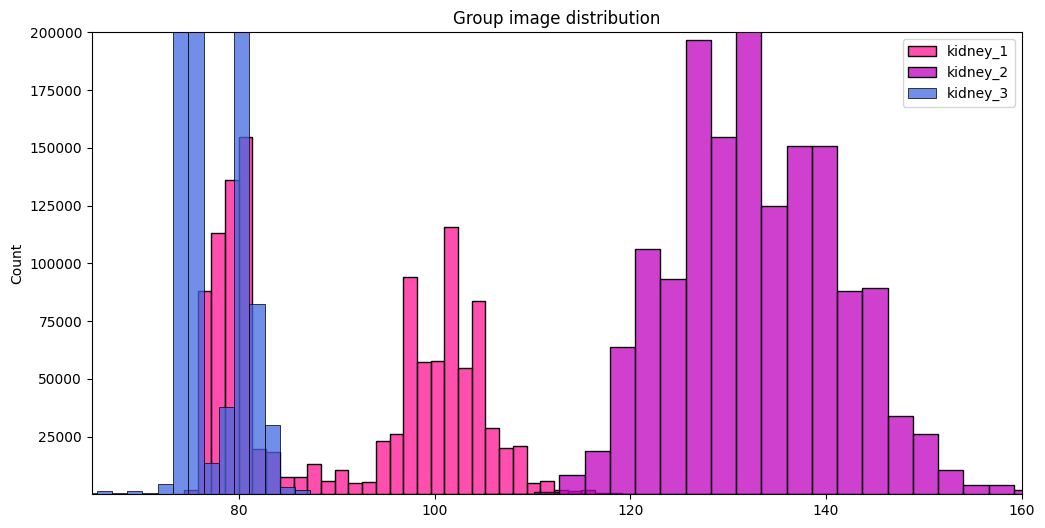

In [9]:
kidney_1 = cv2.imread('/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/0850.tif',cv2.IMREAD_GRAYSCALE)
kidney_2 = cv2.imread('/kaggle/input/blood-vessel-segmentation/train/kidney_2/images/0850.tif',cv2.IMREAD_GRAYSCALE)
kidney_3 = cv2.imread('/kaggle/input/blood-vessel-segmentation/train/kidney_3_sparse/images/0850.tif',cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 6))
plt.title('Group image distribution')
sns.histplot(kidney_1.flatten(), bins = 50, color = 'deeppink')
sns.histplot(kidney_2.flatten(), bins = 50, color = 'm')
sns.histplot(kidney_3.flatten(), bins = 50, color = 'royalblue')
plt.legend(['kidney_1','kidney_2','kidney_3'])
plt.xlim(65, 160)
plt.ylim(65, 200000)

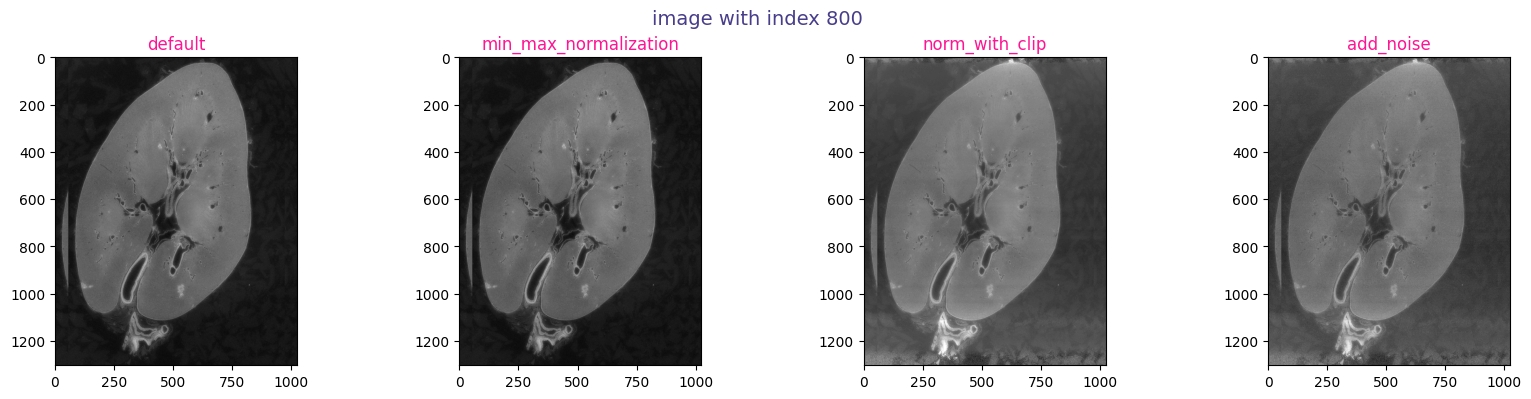

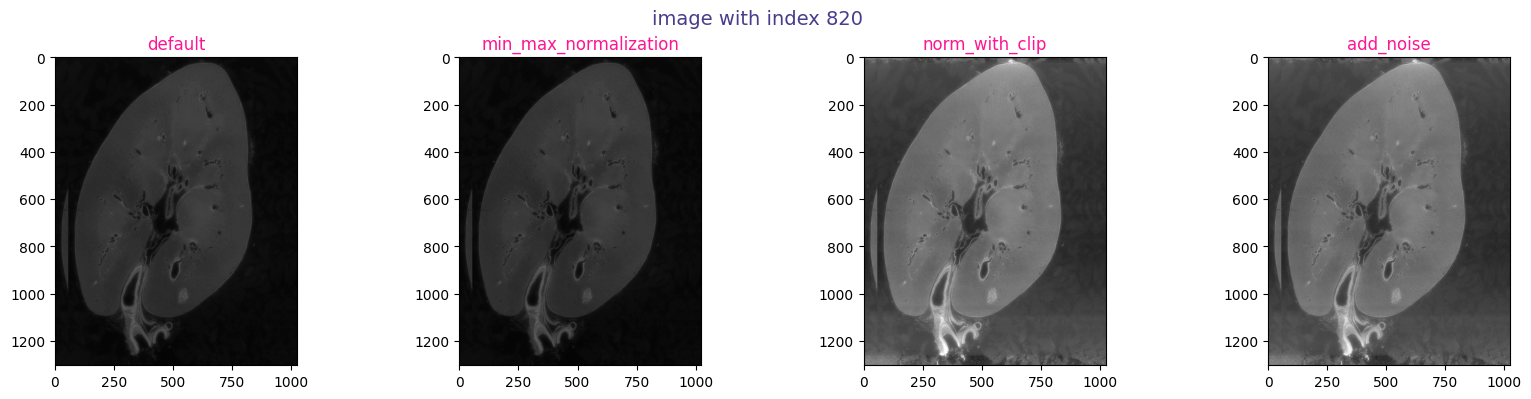

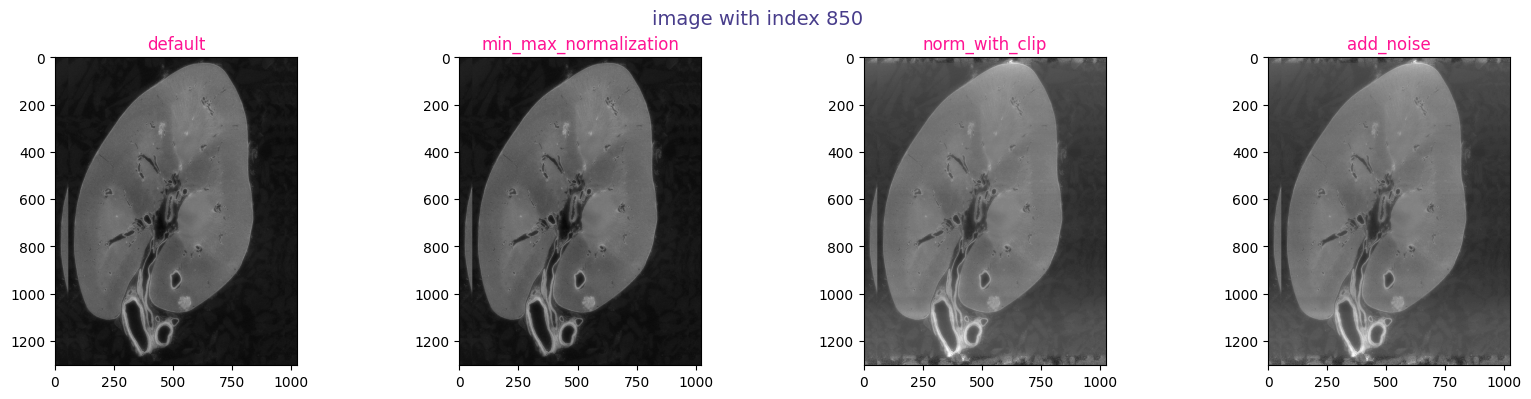

In [10]:
index = [800, 820, 850]
for i in index:
    test_image = cv2.imread(str(df.path_image[i]),cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(20, 4))
    plt.suptitle(f'image with index {i}', y=1, fontsize=14, color='darkslateblue')

    test_image = rotate_to_size(test_image, 1024) #удлиняет по стороне
    test = torch.tensor(test_image.copy())
    plt.subplot(1, 4, 1)
    plt.title('default', color='deeppink')
    plt.imshow(test, cmap='gray')
    
    test=(min_max_normalization(test.to(torch.float16)[None])[0])/255.
    plt.subplot(1, 4, 2)
    plt.title('min_max_normalization', color='deeppink')
    plt.imshow(test.to(torch.float16), cmap='gray')

    test = norm_with_clip(test.to(torch.float16))
    plt.subplot(1, 4, 3)
    plt.title('norm_with_clip', color='deeppink')
    plt.imshow(test, cmap='gray')

    test = add_noise(test, max_randn_rate=0.5, x_already_normed=True)
    plt.subplot(1, 4, 4)
    plt.title('add_noise', color='deeppink')
    plt.imshow(test, cmap='gray')

    plt.show()

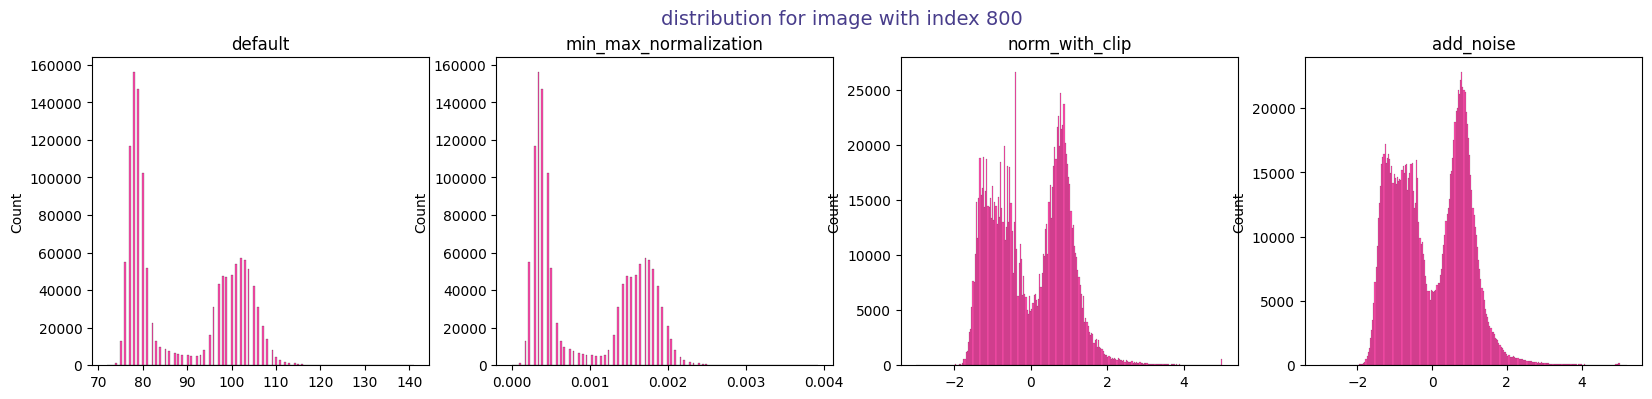

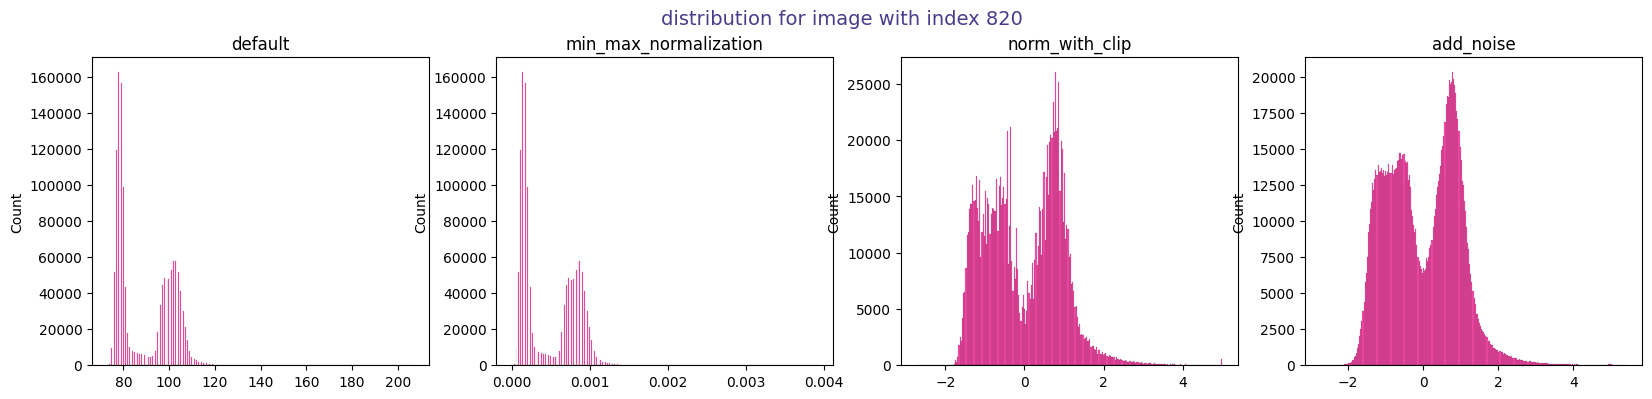

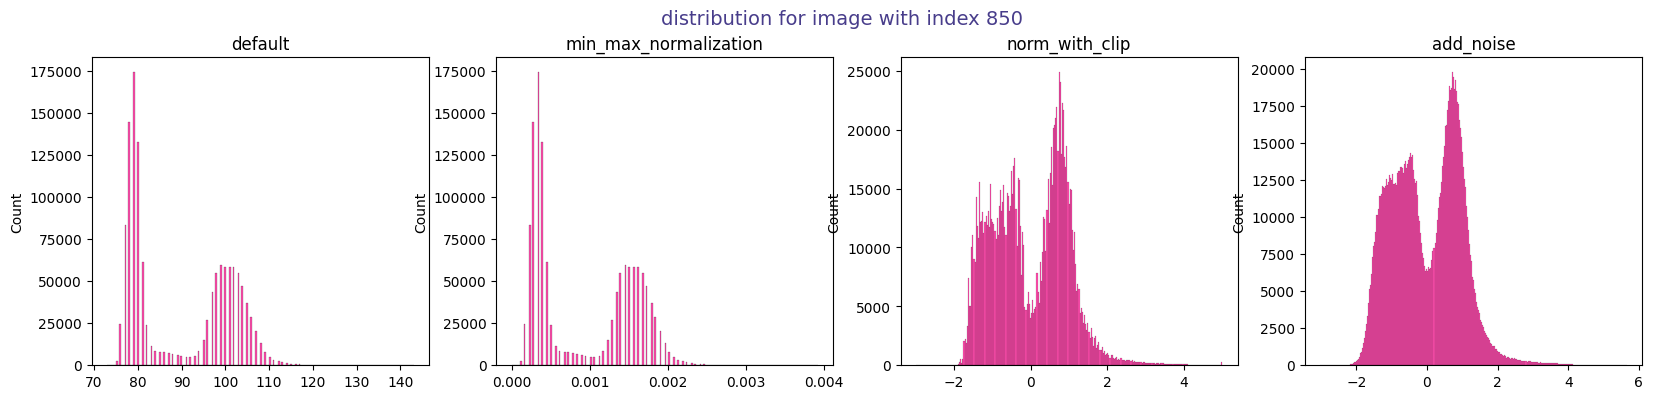

In [11]:
for i in index:
    test_image = cv2.imread(str(df.path_image[i]),cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(20, 4))
    plt.suptitle(f'distribution for image with index {i}', y=1, fontsize=14, color='darkslateblue')
    
    test_image = rotate_to_size(test_image, 1024) #удлиняет по стороне
    test = torch.tensor(test_image.copy())
    plt.subplot(1, 4, 1)
    plt.title('default')
    sns.histplot(test.flatten().numpy(), color = 'deeppink')
    
    test=(min_max_normalization(test.to(torch.float16)[None])[0])/255.
    plt.subplot(1, 4, 2)
    plt.title('min_max_normalization')
    sns.histplot(test.to(torch.float32).flatten().numpy(), color = 'deeppink')

    test = norm_with_clip(test.to(torch.float16))
    plt.subplot(1, 4, 3)
    plt.title('norm_with_clip')
    sns.histplot(test.to(torch.float32).flatten().numpy(), color = 'deeppink')

    test = add_noise(test, max_randn_rate=0.5, x_already_normed=True)
    plt.subplot(1, 4, 4)
    plt.title('add_noise')
    sns.histplot(test.to(torch.float32).flatten().numpy(), color = 'deeppink')

    plt.show()

In [12]:
class SenNetDataloader(Dataset):
    def __init__(self, paths, label):
        self.paths = paths
        self.paths.sort()
        self.label = label
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img = cv2.imread(str(self.paths[index]), cv2.IMREAD_GRAYSCALE)
        img = rotate_to_size(img, size = CFG.resize)
        img = torch.from_numpy(img.copy())
        if self.label:
            img=(img!=0).to(torch.uint8)*255
        else:
            img=img.to(torch.uint8)
        return img

def load_data(paths, label=False):
    data_loader = SenNetDataloader(paths, label)
    data_loader = DataLoader(data_loader, batch_size=16, num_workers=2)  
    data = []
    for x in tqdm(data_loader):
        data.append(x)
    x = torch.cat(data,dim=0)
    del data
    gc.collect()
    if not label:
        x = crop_image(x, chopping_percentile=CFG.chopping_percentile)
        x = (min_max_normalization(x.to(torch.float16)[None])[0]*255).to(torch.uint8)
    return x

class SenNetDataset(Dataset):
    def __init__(self,images:list, masks:list, arg=False):
        super(Dataset,self).__init__()
        self.images = images #list[(C,H,W),...]
        self.masks = masks #list[(C,H,W),...]
        self.image_size = CFG.resize
        self.in_chans = CFG.in_chans
        self.arg = arg
        if arg:
            self.transforms=CFG.transform
        else: 
            self.transforms=CFG.transform_

    def __len__(self) -> int:
        return sum([mask.shape[0]-self.in_chans for mask in self.masks])
    
    def __getitem__(self,index):
        i=0
        for img_ in self.images:
            if index > img_.shape[0]-self.in_chans:
                index-=img_.shape[0]-self.in_chans
                i+=1
            else:
                break
        img = self.images[i]
        mask = self.masks[i]
        
        x_index = (img.shape[1]-self.image_size)//2 #np.random.randint(0,x.shape[1]-self.image_size)
        y_index = (img.shape[2]-self.image_size)//2 # np.random.randint(0,x.shape[2]-self.image_size)
        img = img[index:index+self.in_chans, x_index:x_index+self.image_size, y_index:y_index+self.image_size]
        mask = mask[index+self.in_chans//2, x_index:x_index+self.image_size, y_index:y_index+self.image_size]
        
        data = self.transforms(image=img.numpy().transpose(1,2,0), mask=mask.numpy())
        img = data['image']
        mask = data['mask']>=127
        if self.arg:
            i = np.random.randint(4)
            img = img.rot90(i,dims=(1,2))
            mask = mask.rot90(i,dims=(0,1))
            for i in range(3):
                if np.random.randint(2):
                    img = img.flip(dims=(i,))
                    if i>=1:
                        mask = mask.flip(dims=(i-1,))
        return img, mask


th_up: 119 tensor check: tensor([ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119], dtype=torch.uint8)
th_down: 75 tensor check: tensor([ 75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119], dtype=torch.uint8)


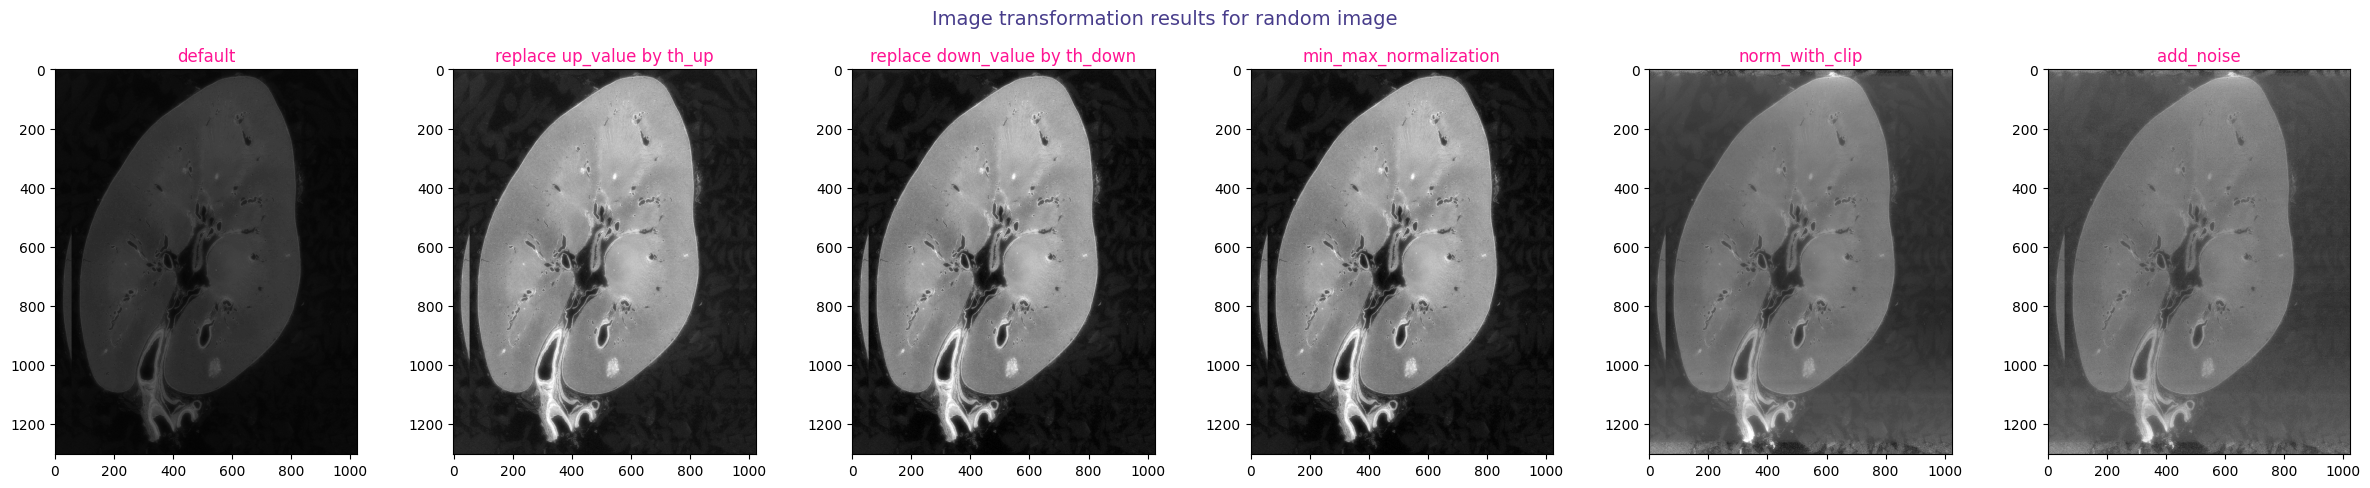

In [13]:
test_image = cv2.imread(str(df.path_image[820]),cv2.IMREAD_GRAYSCALE)
test_image = rotate_to_size(test_image, 1024)
img = torch.from_numpy(test_image.copy())
img=img.to(torch.uint8)

plt.figure(figsize=(30, 5))
plt.suptitle(f'Image transformation results for random image', y=1, fontsize=14, color='darkslateblue')

plt.subplot(1, 6, 1)
plt.title('default', color='deeppink')
plt.imshow(img, cmap='gray')

TH=img.reshape(-1).numpy() #flatten
index = -int(len(TH) * 1e-3)
th_up = np.partition(TH, index)[index] #в копии отсортированного массива все элементы левее индекса меньше индекса, правее - больше
img[img>th_up]=int(th_up) #маска
plt.subplot(1, 6, 2)
plt.title('replace up_value by th_up', color='deeppink')
plt.imshow(img, cmap='gray')
print(f'th_up: \033[1m\033[35m{th_up}\033[0m tensor check:', img.unique())

th_down = np.partition(TH, -index)[-index] #в копии отсортированного массива все элементы левее индекса меньше индекса, правее - больше
img[img<th_down]=int(th_down) #маска
plt.subplot(1, 6, 3)
plt.title('replace down_value by th_down', color='deeppink')
plt.imshow(img, cmap='gray')

print(f'th_down: \033[1m\033[35m{th_down}\033[0m tensor check:', img.unique())

img=min_max_normalization(img.to(torch.float16)[None])[0]
plt.subplot(1, 6, 4)
plt.title('min_max_normalization', color='deeppink')
plt.imshow(img, cmap='gray')

img = norm_with_clip(img.to(torch.float16))
plt.subplot(1, 6, 5)
plt.title('norm_with_clip', color='deeppink')
plt.imshow(img, cmap='gray')

img = add_noise(img, max_randn_rate=0.5, x_already_normed=True)
plt.subplot(1, 6, 6)
plt.title('add_noise', color='deeppink')
plt.imshow(img, cmap='gray')

plt.show()

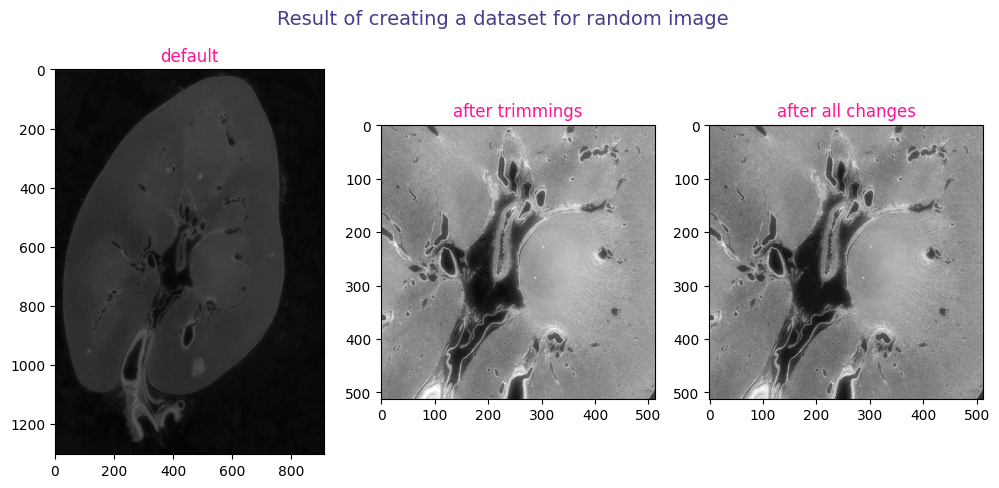

In [14]:
test_image = cv2.imread(str(df.path_image[820]),cv2.IMREAD_GRAYSCALE)
test_image = rotate_to_size(test_image, 512)
img = torch.from_numpy(test_image.copy())
img=img.to(torch.uint8)


plt.figure(figsize=(12, 5))
plt.suptitle(f'Result of creating a dataset for random image', y=1, fontsize=14, color='darkslateblue')

plt.subplot(1, 3, 1)
plt.title('default', color='deeppink')
plt.imshow(img, cmap='gray')

img = crop_image(img, chopping_percentile=CFG.chopping_percentile)
img=min_max_normalization(img.to(torch.float16)[None])[0]

img = img.unsqueeze(0)
x_index = (img.shape[1]-512)//2 
y_index = (img.shape[2]-512)//2 
img = img[:, x_index:x_index+512, y_index:y_index+512]


plt.subplot(1, 3, 2)
plt.title('after trimmings', color='deeppink')
plt.imshow(img[0,:,:], cmap='gray')

img = norm_with_clip(img.to(torch.float32))
img = add_noise(img, max_randn_rate=0.5, x_already_normed=True)
plt.subplot(1, 3, 3)
plt.title('after all changes', color='deeppink')
plt.imshow(img[0,:,:], cmap='gray')

plt.show()


In [15]:
train_images, train_labels = [], []
num_part = 1

for group in [df.group.unique()[0]]:
    if group in ('kidney_3_dense', 'kidney_1_voi'):
        continue
    df_ = df[df.group==group]
    for part, i in enumerate(range(0, len(df_), len(df_)//num_part)):
        images = load_data(df_.iloc[i:i+len(df_)//num_part]['path_image'].values, label=False)
        masks = load_data(df_.iloc[i:i+len(df_)//num_part]['path_mask'].values, label=True)
        print(f'{group} part {part+1} train images: {images.shape}, train masks: {masks.shape}')
        train_images.extend([images, images.permute(1,2,0), images.permute(2,0,1)])
        train_labels.extend([masks, masks.permute(1,2,0), masks.permute(2,0,1)])
        del images, masks
        gc.collect()

train_dataset = SenNetDataset(train_images,train_labels, arg=True)
train_loader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, num_workers=2, shuffle=True, pin_memory=True)
#del train_images, train_labels
    
valid_images = load_data(df[df.group=='kidney_3_dense']['path_image'].values, label=False)
valid_labels = load_data(df[df.group=='kidney_3_dense']['path_mask'].values, label=True)
print(f'valid images: {valid_images.shape}, valid masks: {valid_labels.shape}')

valid_dataset = SenNetDataset([valid_images],[valid_labels])
valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_batch_size, num_workers=2, shuffle=False, pin_memory=True)
del valid_images,valid_labels
gc.collect()


loaders = {'train': train_loader, 'valid': valid_loader} #, 'test': test_loader}

100%|██████████| 143/143 [00:24<00:00,  5.81it/s]


kidney_1_dense part 1 train images: torch.Size([2279, 1303, 912]), train masks: torch.Size([2279, 1303, 912])


100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


valid images: torch.Size([501, 1706, 1510]), valid masks: torch.Size([501, 1706, 1510])


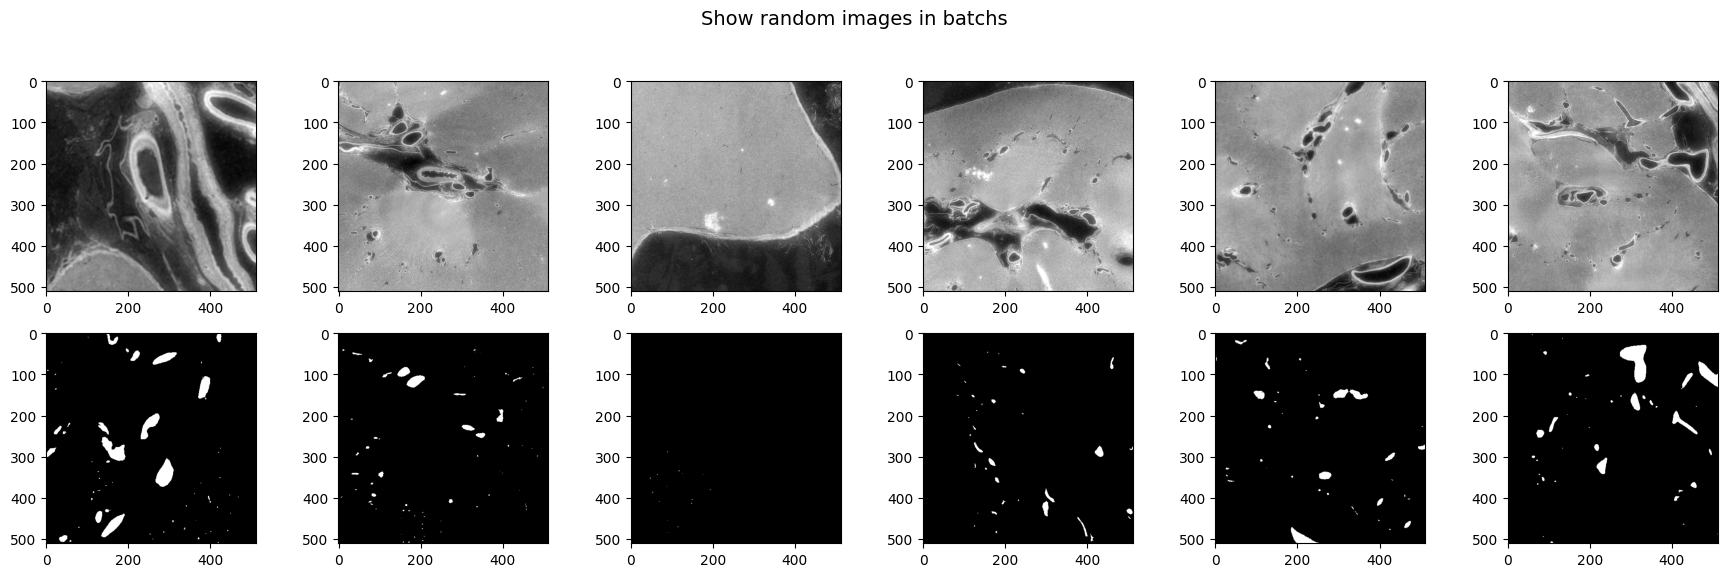

In [16]:
random_characters = np.random.randint(0, len(train_dataset), 6)

plt.figure(figsize=(22, 6))
plt.suptitle(f'Show random images in batchs', y=1, fontsize=14)
for i, index in enumerate(random_characters):
    plt.subplot(2, 6, i+1)
    plt.imshow(train_dataset[index][0][0,:,:], cmap='gray')
    
    plt.subplot(2, 6, i+1+6)
    plt.imshow(train_dataset[index][1], cmap='gray')
plt.show()

## TRAINING

In [17]:
def dice_loss(y_true, y_pred, thr=0.5, dim=(-1,-2), epsilon=0.001):
    y_pred = y_pred.sigmoid()
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean()
    return dice

def iou(y_true, y_pred, thr=0.5,):
    
    SMOOTH = 0.001
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thr).to(torch.float32)
    intersection = (y_pred*y_true).sum()
    union = (y_true+y_pred - y_true*y_pred).sum()     
    iou = ((intersection + SMOOTH) / (union + SMOOTH)).mean()  
    return iou  

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.sigmoid()   
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice
    
    
def np_metric(y_pred, y_true, thr=0.5):
    y_pred = y_pred.sigmoid()
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    hit = (y_pred*y_true).sum()
    fp  = (y_pred*(1-y_true)).sum()
    t_sum = t.sum()
    p_sum = p.sum()
    return hit, fp, t_sum, p_sum


#criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss()

In [18]:
def show_result(data, best_score):
    plt.figure(figsize=(22, 5))
        
    plt.subplot(1, 3, 1)
    sns.lineplot(data=data, x='epoch', y='train_loss', color = 'darkcyan')
    sns.lineplot(data=data, x='epoch', y='valid_loss', color = 'cornflowerblue')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'valid_loss'])
    plt.title('Loss values')

    plt.subplot(1, 3, 2)
    sns.lineplot(data=data, x='epoch', y='train_dice_loss', color = 'darkcyan')
    sns.lineplot(data=data, x='epoch', y='valid_dice_loss', color = 'cornflowerblue')
    sns.lineplot(data=data, x='epoch', y=0.5, style=True, dashes=[(3,3)], color = 'tan')
    mask = np.array(data['valid_dice_loss'])==best_score
    plt.scatter(np.array(data['epoch'])[mask], np.array(data['valid_dice_loss'])[mask], color='deeppink', s=40, marker='^')
    plt.ylabel('score')
    plt.legend(['train_dice_loss', 'valid_dice_loss', 'threshold'])
    plt.title('Score: dice-loss')
    
    plt.subplot(1, 3, 3)
    sns.lineplot(data=data, x='epoch', y='train_iou', color = 'darkcyan')
    sns.lineplot(data=data, x='epoch', y='valid_iou', color = 'cornflowerblue')
    sns.lineplot(data=data, x='epoch', y=0.5, style=True, dashes=[(3,3)], color = 'tan')
    plt.ylabel('score')
    plt.legend(['train_iou', 'valid_iou', 'threshold'])
    plt.title('Score: iou')
        
    plt.show()   

In [19]:
def show_preds(img, target, preds, num=6):
    plt.figure(figsize=(22, 8))
    
    if num>len(img):
        num = len(img)

    for i in range(num):
        plt.subplot(3, num, i+1)
        plt.imshow(np.rollaxis(img[i].cpu().detach().numpy(), 0, 3), cmap='gray')
        plt.title('Gemma')
        plt.axis('off')

        plt.subplot(3, num, i+num+1)
        target = target.unsqueeze(1)
        plt.imshow(color.label2rgb(target[i, 0].cpu().detach().numpy(), colors = ['deeppink'],  alpha=0.35))
        plt.title('Vasculature true')
        plt.axis('off')
    
        plt.subplot(3, num, i+num*2+1)
        plt.imshow(color.label2rgb(preds[i, 0].cpu().detach().numpy(), colors = ['deeppink'],  alpha=0.35))
        plt.title('Vasculature predict')
        plt.axis('off')

In [20]:
def train(model, optimizer, loss_fn, epochs, loaders, scheduler):
    
    scaler =  torch.cuda.amp.GradScaler() 
    best_score = 0
    
    for epoch in range(1, epochs+1):
        model.train()
        result['epoch'].append(epoch)
        for mode, dataloader in tqdm(loaders.items()):
            loss_score, dice_score, iou_score, valid_loss = 0, 0, 0, 0
            
            for i,(X_batch, Y_batch) in enumerate(dataloader):
                X_batch = X_batch.to(device, torch.float32)
                Y_batch = Y_batch.to(device, torch.float32)
                X_batch = norm_with_clip(X_batch.reshape(-1,*X_batch.shape[2:])).reshape(X_batch.shape)
                
                if mode =='train':
                    X_batch = add_noise(X_batch, max_randn_rate=0.5, x_already_normed=True)
                    with torch.cuda.amp.autocast(enabled=True):
                        Y_pred = model(X_batch)
                        loss = loss_fn(Y_pred, Y_batch)
                    
                else: 
                    model.eval()  
                    with torch.no_grad(): 
                        Y_pred = model(X_batch)
                        loss = loss_fn(Y_pred, Y_batch)
                        
                dice_lst = dice_loss(Y_batch, Y_pred).cpu().detach()
                iou_lst = iou(Y_batch, Y_pred).cpu().detach()
                
                loss_score = (loss_score*i+loss.item())/(i+1)
                dice_score = (dice_score*i+dice_lst)/(i+1)
                iou_score = (iou_score*i+iou_lst)/(i+1)


                if mode =='train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()  
                    optimizer.zero_grad()
            
            result[str(mode)+'_loss'].append(loss_score)
            result[str(mode)+'_dice_loss'].append(float(dice_score.numpy()))
            result[str(mode)+'_iou'].append(float(iou_score.numpy()))
            
            if mode =='valid':
                if dice_score > best_score:
                    best_score = dice_score
                    path_weights = 'weights_Dice{:.4f}_Loss{:.4f}_epoch{:.0f}.bin'.format(dice_score, loss_score, epoch)
                    torch.save(model.state_dict(), path_weights)   
                valid_loss = loss_score
            lr = optimizer.param_groups[0]['lr']
            scheduler.step()
            
        clear_output(wait=True)
        print(f'epoch training: {epoch}, lr optimizer: {lr}, loss value validate:{valid_loss:10.4f}, dice validate:{dice_score:10.4f}, iou validate:{iou_score:10.4f}') #
        print()
        
        #show_preds(X_batch, Y_batch, Y_pred, num=6)
        show_result(result, best_score)
        
        torch.cuda.empty_cache()
        gc.collect()

In [21]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=1,
            activation=None,)

    def forward(self, image):
        output = self.model(image)
        return output[:,0]


def build_model(weight='imagenet'):
    from dotenv import load_dotenv
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.to(device)

In [22]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/se-net-pretrained-imagenet-weights/* /root/.cache/torch/hub/checkpoints/

In [23]:
model = build_model()
model = DataParallel(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=len(train_dataset), epochs=29, pct_start=0.1)
torch.cuda.empty_cache()
gc.collect()

model_name Unet
backbone se_resnext50_32x4d


34159

epoch training: 28, lr optimizer: 4.004224881998613e-06, loss value validate:    0.2701, dice validate:    0.8264, iou validate:    0.4571



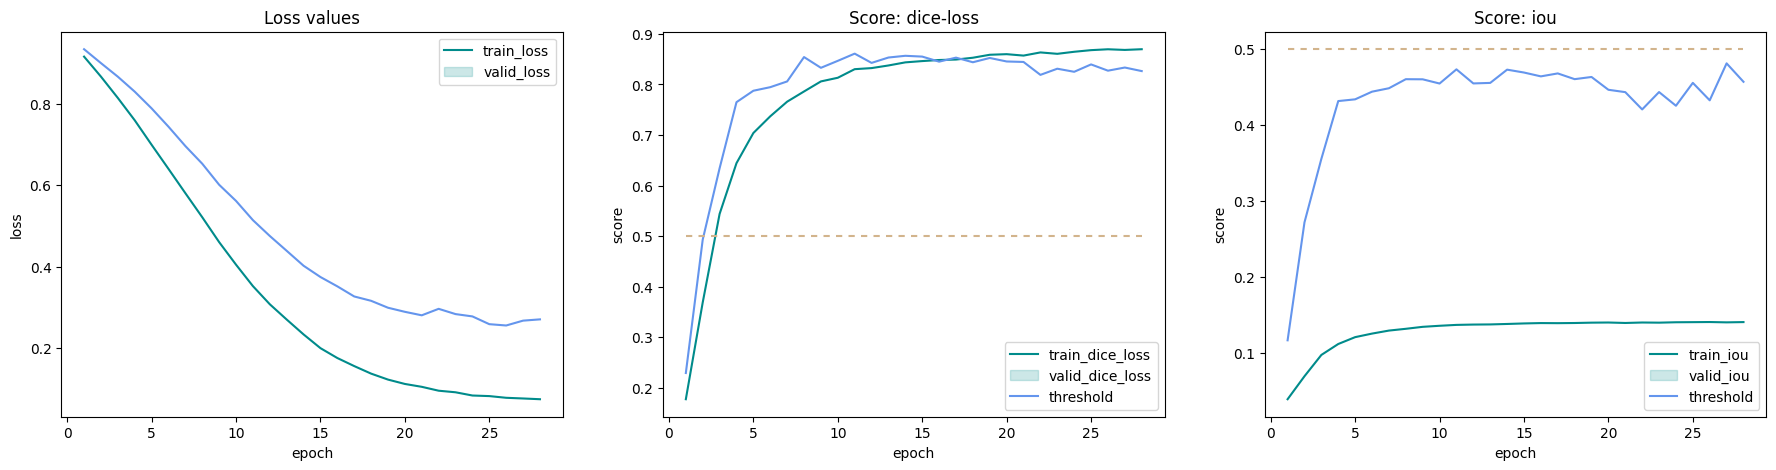

In [24]:
result = {
    'epoch':[],'train_loss':[],'valid_loss':[],'train_dice_loss':[],'valid_dice_loss':[], 'train_iou':[], 'valid_iou':[]
}
epochs = 28
train(model, optimizer, criterion, epochs, loaders, scheduler)

## TEST

In [25]:
test_images, test_labels = [], []
num_part = 2

df_ = df[df.group=='kidney_2']
for part, i in enumerate(range(0, len(df_), len(df_)//num_part)):
    images = load_data(df_.iloc[i:i+len(df_)//num_part]['path_image'].values, label=False)
    masks = load_data(df_.iloc[i:i+len(df_)//num_part]['path_mask'].values, label=True)
    print(f'{group} part {part+1} test images: {images.shape}, test masks: {masks.shape}')
    test_images.append(images)
    test_labels.append(masks)
    del images, masks
    gc.collect()

test_dataset = SenNetDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_batch_size, num_workers=2, shuffle=False, pin_memory=True)
del test_images,test_labels
gc.collect()

100%|██████████| 70/70 [00:16<00:00,  4.22it/s]


kidney_1_dense part 1 test images: torch.Size([1108, 1041, 1511]), test masks: torch.Size([1108, 1041, 1511])


100%|██████████| 70/70 [00:16<00:00,  4.23it/s]


kidney_1_dense part 2 test images: torch.Size([1108, 1041, 1511]), test masks: torch.Size([1108, 1041, 1511])


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


kidney_1_dense part 3 test images: torch.Size([1, 1041, 1511]), test masks: torch.Size([1, 1041, 1511])


0

In [26]:
model=build_model()
model = DataParallel(model)
#model.load_state_dict(torch.load('/kaggle/working/weights_Dice0.5260_Loss0.9082_epoch3.bin'))
#model.to(device)
model.eval()
print()

model_name Unet
backbone se_resnext50_32x4d



In [27]:
loss_score = 0
dice_score = 0
for i,(X_batch, Y_batch) in enumerate(test_loader):
    X_batch = X_batch.to(device, torch.float32)
    Y_batch = Y_batch.to(device, torch.float32)
    X_batch = norm_with_clip(X_batch.reshape(-1,*X_batch.shape[2:])).reshape(X_batch.shape)
    with torch.no_grad(): 
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
    
    dice_lst = dice_loss(Y_batch, Y_pred).cpu().detach()     
    loss_score = (loss_score*i+loss.item())/(i+1)
    dice_score = (dice_score*i+dice_lst)/(i+1)

print(f'metrics for test kidney_2. loss: {loss_score}, dice_score: {float(dice_score.numpy())}')

metrics for test kidney_2. loss: 0.9748240739429901, dice_score: 0.024714330211281776


## RESUME

Стратегия обучения во многом была выстроена вокруг того, чтобы привести распределение в изображениях почки 1 к распределению почки 3, на которой осуществлялась валидация данных. Нельзя достоверно полагать, что распределение почки 5 (которое скрыто от нас в данных) похоже на 1 и 3, но при загрузке данных мы получили хороший результат dice_score = 0,866
Посмотрим еще раз:
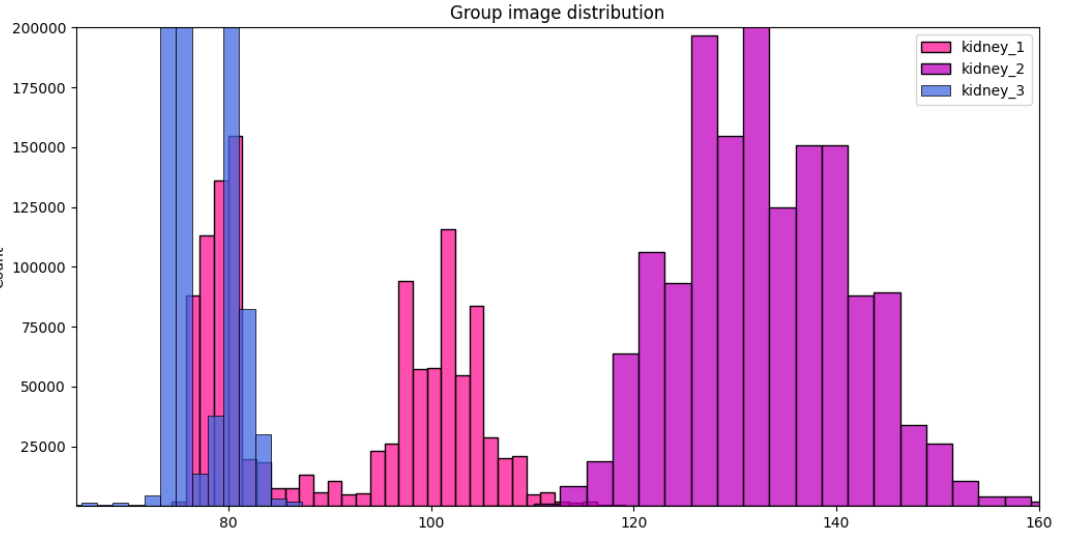
Распределение почки 2 существенно отличается от 1 и 3 - отсюда и низкий скор на тесте. Стратегия оказалась не эффективной.
При этом регулируя величину chopping_percentile, которая позволяет накладывать маски, отсекающие значения в заданном диапазоне,  мы можем выровнять метрики и по почке 2, но скорее всего, что это решение будет являтся универсальным для других групп изображений, а лишь подгонит данные под те, что у нас есть в наличии.
Как показал приватный скор потеря в метрике при таких решениях составляет около 0,4.